## Setup Libraries


In [38]:
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import scipy.stats as sp
import scipy.optimize as opti
from matplotlib import style
import yfinance as yfin
from pandas_datareader import data as pdr

%matplotlib inline

## VIX Data

Extract VIX closing data from Yahoo finance using their API.

In [112]:
yfin.pdr_override()
vix = pdr.get_data_yahoo('^VIX', start='1990-01-01', end='2023-07-23')['Close']

[*********************100%***********************]  1 of 1 completed


Format raw data as numpy arrays and generate training data. Training data follows standard 80-20 split typically used for training sequential data. This study focuses on the returns as training data to better stabilize the mean and variance over time.

In [40]:
dates = vix.index.to_numpy()
levels = vix.to_numpy()
returns = (levels[1:] - levels[:-1])/(levels[:-1])

N_train = int(0.8*returns.shape[0])
train_returns = returns[:N_train]
test_returns = returns[N_train:]

## Preliminary Visualizations

Plotting the raw data below, we affirm that VIX, as a time series, is not independent and identically distributed data. 

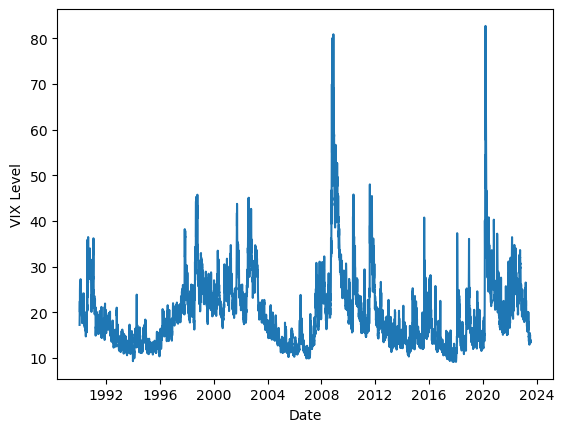

In [41]:
plt.figure()
plt.plot(dates, levels)
plt.xlabel('Date')
plt.ylabel("VIX Level")
plt.show()

Using the returns, however, we obtain a data set that better resembles independent Gaussian noise. Here, plotting the zero mean independent Gaussian noise on top of the VIX displays their similarities.

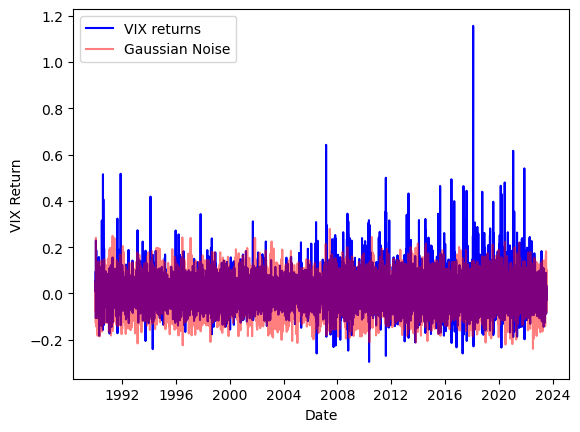

In [42]:
gauss_noise = np.random.normal(loc=0, scale=0.07, size=returns.shape[0])

plt.figure()
plt.plot(dates[1:], returns, c='b', label='VIX returns')
plt.plot(dates[1:], gauss_noise, alpha=0.5, c='r', label='Gaussian Noise')
plt.xlabel('Date')
plt.ylabel("VIX Return")
plt.legend()
plt.show()

The historgram below gives us a better visualization of the similarities between the VIX and generated Gaussian noise.

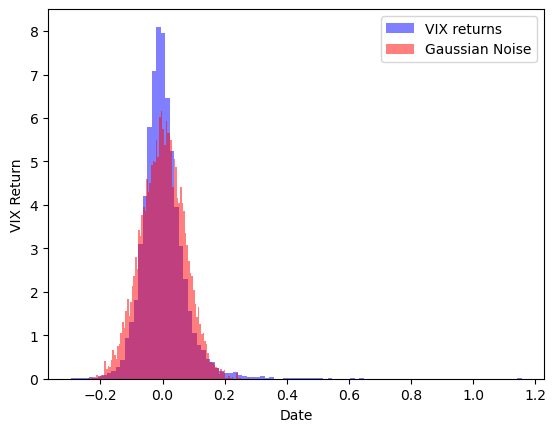

In [96]:
plt.figure()
plt.hist(returns, color='b', alpha=0.5, bins=100, density=True,label='VIX returns')
plt.hist(gauss_noise, color='r', alpha=0.5, bins=100, density=True, label='Gaussian Noise')
plt.xlabel('Date')
plt.ylabel("VIX Return")
plt.legend()
plt.show()

For consistency, we plot the test data overlapping the training data.

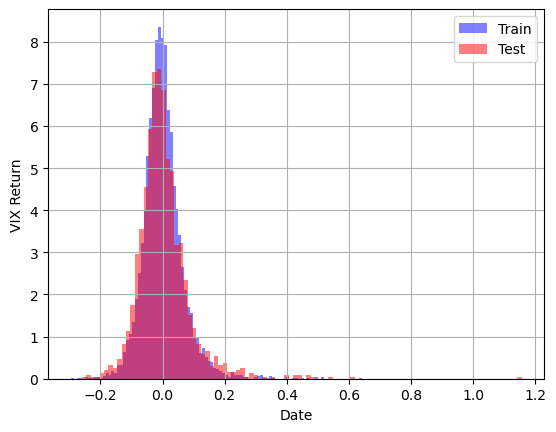

In [95]:
plt.figure()
plt.hist(train_returns, color='b', label='Train', alpha=0.5, bins=100, density=True)
plt.hist(test_returns, color='r', label='Test', alpha=0.5, bins=100, density=True)
plt.xlabel('Date')
plt.ylabel("VIX Return")
plt.legend()
plt.grid(True)
plt.show()

## Fitting Vix Returns

Below, we will fit the Gaussian and Student-t distributions to the VIX data. Since the returns better resemble independent and identically distributed data, we will assume that the training data also follows suit.

### Gaussian Fit

We construct a general function that accepts VIX data as input and outputs the maximum likelyhood estimator (MLE) of the mean and variance.

In [113]:
def gaussian_mle(data):
    n = len(data)
    mean_est = np.mean(data)
    variance_est = np.var(data, ddof=0)
    return mean_est, variance_est

Instantiate MLE mean and variance with training data. 

In [114]:
mu_train, sigma2_train = gaussian_mle(train_returns)

We can generate different values based on how much of the training data is incorportated.

In [115]:
sample_sizes = range(100, len(train_returns) + 1,30)
mu_estimates = []
sigma2_estimates = []

for size in sample_sizes:
    mu, sigma_sq = gaussian_mle(train_returns[:size])
    mu_estimates.append(mu)
    sigma2_estimates.append(sigma_sq)
train_mle = np.random.normal(loc = mu_train, scale = sigma2_train, size = returns.shape[0])

Below we notice that, as more data is incorporated, the mean and variance estimates converge to their true values.

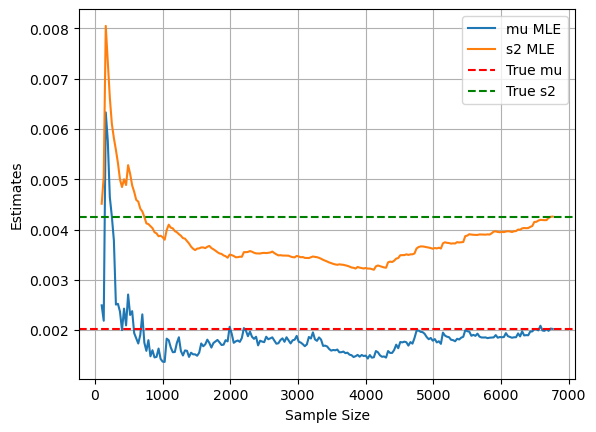

In [116]:
plt.figure()
plt.plot(sample_sizes, mu_estimates, label="mu MLE")
plt.plot(sample_sizes, sigma2_estimates, label="s2 MLE") 
plt.axhline(y=mu_train, color='r', linestyle='--', label="True mu") 
plt.axhline(y=sigma2_train, color='g', linestyle='--', label="True s2") 
plt.xlabel("Sample Size")
plt.ylabel("Estimates")
plt.legend()
plt.grid(True)
plt.show()

Plotting the fit over the observed samples, we notice that the Gaussian distribution has a generally similar shape, however it is not an accurate representation of the data. The data doesnt follow an entirely symmetrical curve as the Gaussian would infer. We also notice that the peaks and tails of the data are not accurately depicted in the Gaussian fit.

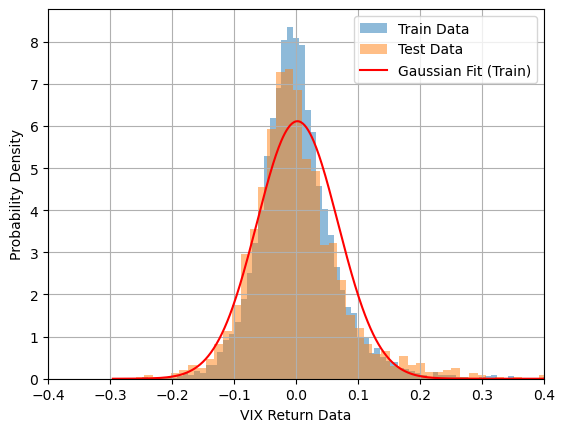

In [117]:
plt.figure()
plt.hist(train_returns, bins=100, density=True, alpha=0.5, label="Train Data")
plt.hist(test_returns, bins=100, density=True, alpha=0.5, label="Test Data")
x_range = np.linspace(min(returns), max(returns), 1000)
fit_mu, fit_sigma2 = gaussian_mle(train_returns)
plt.plot(x_range, sp.norm.pdf(x_range, fit_mu, np.sqrt(fit_sigma2)), 'r', label="Gaussian Fit (Train)")
plt.xlim([-0.4,0.4])
plt.xlabel("VIX Return Data")
plt.ylabel("Probability Density")
plt.legend()
plt.grid(True)
plt.show()

### Student-t Fit

A similar distribution to the Gaussian, the Student-t fit is also parameterized by a mean and variance. It introduces an additional parameter v, which refers to the degrees of freedom.

The pdf of this distribution doesn't allow for a striaghtforward calculation for the MLE. Instead, we derive a method of moments estimator to visualize a fit for this data.

Since the Student-t distribution better resembles the Gaussian as more degrees of freedom are introduced, we write the Method of Moments (MOM) function as a function of v.

In [118]:
def student_t_moments(data, v):
    sample_mean = np.mean(data)
    sample_variance = np.var(data, ddof=1)  
    sample_kurtosis = sp.kurtosis(data, fisher = False )
    tau_sq_mom = sample_variance * ((v - 2) / v)
    mu_mom = sample_mean
    v_mom = ((6)/(sample_kurtosis-3))+4

    return mu_mom, tau_sq_mom, v_mom

In [107]:
v = 3
mu_mom, tau_sq_mom, v_mom = student_t_moments(train_returns,v)
print(f"Estimates for v = 3: mu_mom = {mu_mom}, tau_sq_mom = {tau_sq_mom}, v_mom = {v_mom}")

Estimates for v = 3: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.0014193287665660494, v_mom = 4.836105658324522


We can plot a fit to the fixed value (3) initially to give us general intuition on our progress. We want a higher peak from the Gaussian so we look towards the lower values in degrees of freedom.

Below, we notice that we overshot our estimate

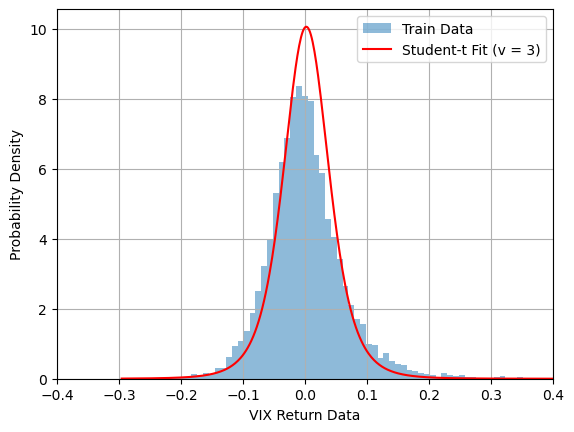

In [108]:
plt.figure()
plt.hist(train_returns, bins=100, density=True, alpha=0.5, label="Train Data")
x_range = np.linspace(min(returns), max(returns), 1000)
fit_pdf = sp.t.pdf(x_range, v_mom, mu_mom, np.sqrt(tau_sq_mom))
plt.plot(x_range, fit_pdf, 'r', label="Student-t Fit (v = 3)")
plt.xlabel("VIX Return Data")
plt.ylabel("Probability Density")
plt.xlim([-0.4,0.4])
plt.legend()
plt.grid(True)
plt.show()

Visualizing the change in v here, we confirm that the fit begins to appear more Gaussian as we increase the degrees of freedom.

Estimates for v = 4: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.002128993149849074, v_mom = 4.836105658324522


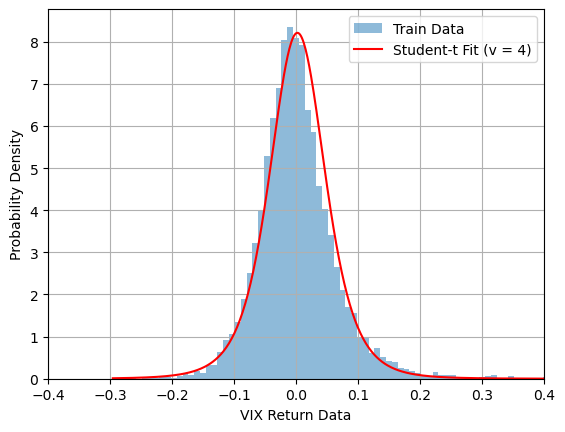

Estimates for v = 5: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.002554791779818889, v_mom = 4.836105658324522


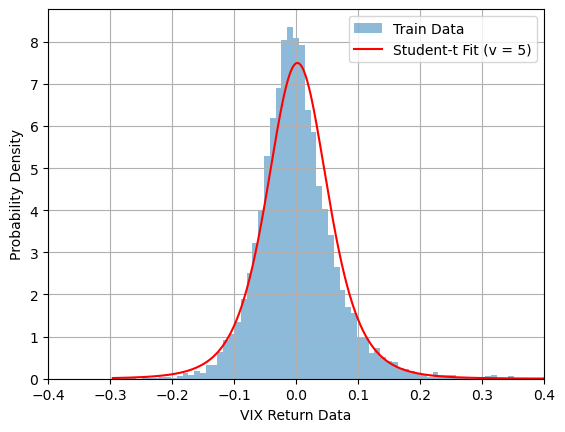

Estimates for v = 6: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.002838657533132099, v_mom = 4.836105658324522


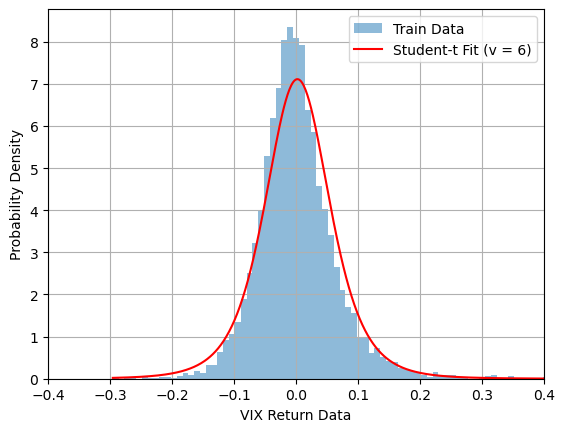

Estimates for v = 7: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.0030414187854986775, v_mom = 4.836105658324522


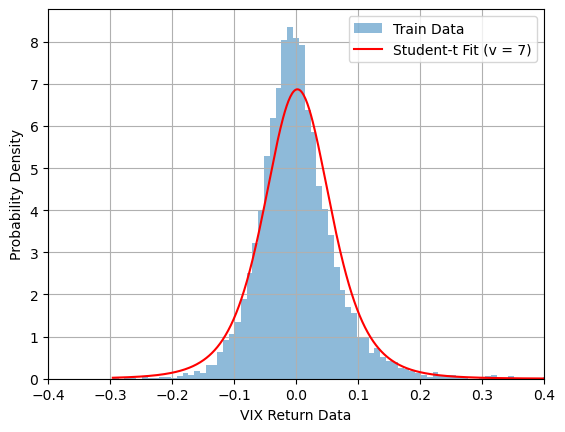

Estimates for v = 8: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.0031934897247736112, v_mom = 4.836105658324522


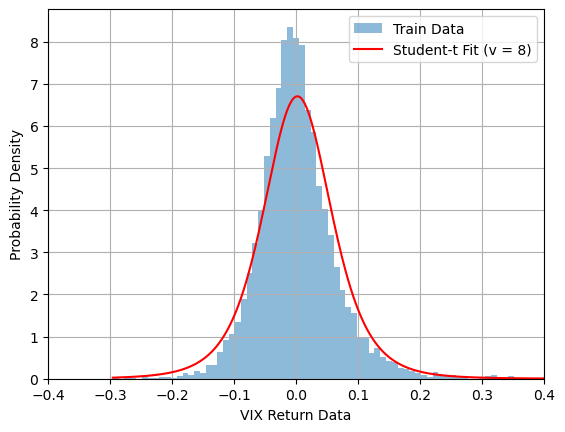

Estimates for v = 9: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.0033117671219874485, v_mom = 4.836105658324522


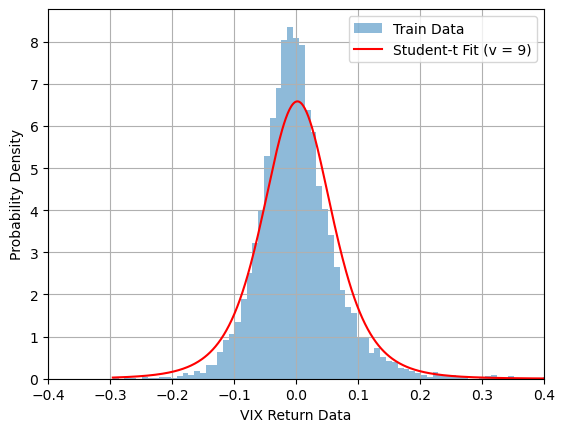

Estimates for v = 10: mu_mom = 0.0020310064503793824, tau_sq_mom = 0.0034063890397585186, v_mom = 4.836105658324522


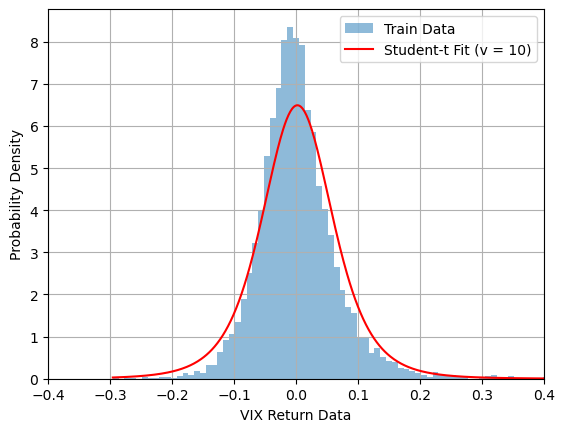

In [119]:
v_values = range(4, 11)
for v in v_values:
    mu_mom, tau_sq_mom, v_mom = student_t_moments(train_returns, v)
    print(f"Estimates for v = {v}: mu_mom = {mu_mom}, tau_sq_mom = {tau_sq_mom}, v_mom = {v_mom}")

    plt.figure()
    plt.hist(train_returns, bins=100, density=True, alpha=0.5, label="Train Data")
    x_range = np.linspace(min(returns), max(returns), 1000)
    fit_pdf = sp.t.pdf(x_range, v_mom, mu_mom, np.sqrt(tau_sq_mom))
    plt.plot(x_range, fit_pdf, 'r', label=f"Student-t Fit (v = {v})")
    plt.xlabel("VIX Return Data")
    plt.ylabel("Probability Density")
    plt.xlim([-0.4,0.4])
    plt.legend()
    plt.grid(True)
    plt.show()

## Model Comparison

An assessment of each model can be made by correlating their likelihoods. 

In [121]:
gaussian_mu, gaussian_sigma2 = gaussian_mle(train_returns)

nu_values = range(4, 11)
student_t_params = [student_t_moments(train_returns, v) for v in nu_values]

gaussian_log_likelihood = np.sum(sp.norm.logpdf(test_returns, loc=gaussian_mu, scale=np.sqrt(gaussian_sigma2)))


student_t_log_likelihoods = []
for v, (mu_mom, tau_sq_mom, v_mom) in zip(nu_values, student_t_params):
    student_t_log_likelihoods.append(np.sum(sp.t.logpdf(test_returns, df=v_mom, loc=mu_mom, scale=np.sqrt(tau_sq_mom))))

print("Gaussian Log-Likelihood:", gaussian_log_likelihood)
print("Student-t Log-Likelihoods:", student_t_log_likelihoods)

Gaussian Log-Likelihood: 1569.127039387939
Student-t Log-Likelihoods: [1950.5342928635296, 1985.432517420413, 1997.1303010129225, 2001.565306407586, 2003.2024191300945, 2003.630315878759, 2003.5033473505466]


## Conclusion

We can conclude that the best fit for this data is the Student-t fit at approx. 4 degrees of freedom. The Gaussian model and log-likelyhood do not capture the behavior of the distribution at the tails and the peak. The Gaussian tails would suggest that this data favors deviations from the mean more than is depicted. This is also affirmed by the Student-t distribution approaching the Gaussian as we increase v. 

The Student-t fit captures the peak and tails of the data's pdf accurately. The log-likelyhood of the distribution follows to be reliable for the data set.